In [1]:
library(dplyr)
library(ggplot2)
library(data.table)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
# load calls from 05 ngc
cond9_calls <- readRDS("CRISPR9_calls.rds")
# dasa
dasa1_calls <- readRDS("DASA1_calls.rds")
dasa2_calls <- readRDS("DASA2_calls.rds")
dmso1_calls <- readRDS("DMSO1_calls.rds")
dmso2_calls <- readRDS("DMSO2_calls.rds")
#total_cells <- nrow(calls)
#head(calls)

In [3]:
dim(cond9_calls)

[1] 6692    8

# Better method

In [5]:
make_call_count_df <- function(df, dataset = ""){
	df$true_cols <- apply(df, 1, function(data)
		names(which(data == T)))
		#sub("-.*", "", names(which(data == T))))
	id_list <- c()
	for(row in 1:nrow(df)){
		trues <- sum(df[row,1:ncol(df)-1])
		if(trues > 2){
			id_list=append(id_list, "doublet") # 2+ guides in diff genes
		} else if (trues == 1){
			# OLD: Differentiated between ps_1 and ps_2
			# id_list=append(id_list, paste0("ps_", substr(df[row,]$true_cols, nchar(df[row,]$true_cols), nchar(df[row,]$true_cols)))) 
			id_list=append(id_list, "ps_1_or_2") # Now just marking as single guide
		} else if (trues == 0){
			id_list=append(id_list, "negative") # no ps
		} else if (trues == 2){
			# check if both guides belong to the same gene
			parts <- strsplit(unname(unlist(df$true_cols[1])), ",")
			modified_string <- sapply(parts, function(part) {
				sub("-.*", "", part)
			})
			if(all(modified_string == modified_string[1])) {id_list=append(id_list, "both_ps")}
			else {id_list=append(id_list, "doublet")}
		}
	}
	ps_counts <- as.data.frame(table(id_list))
	# Calculate total
	total <- sum(ps_counts$Freq)
	# Calculate percentages of the total
	ps_counts$Percent <- ps_counts$Freq / total * 100

	# OLD: Had separate ps_1 and ps_2 levels
	# ps_counts$id_list <- factor(ps_counts$id_list, levels = c("negative", "doublet", "both_ps", "ps_2", "ps_1"))
	# NEW: Combined ps levels
	ps_counts$id_list <- factor(ps_counts$id_list, levels = c("negative", "doublet", "both_ps", "ps_1_or_2"))
	ps_counts$dataset <- dataset
	return(ps_counts)
}

In [6]:
cond9_counts <- make_call_count_df(cond9_calls, dataset = "cond9")
dasa1_counts <- make_call_count_df(dasa1_calls, dataset = "DASA1")
dasa2_counts <- make_call_count_df(dasa2_calls, dataset = "DASA2")
dmso1_counts <- make_call_count_df(dmso1_calls, dataset = "DMSO1")
dmso2_counts <- make_call_count_df(dmso2_calls, dataset = "DMSO2")

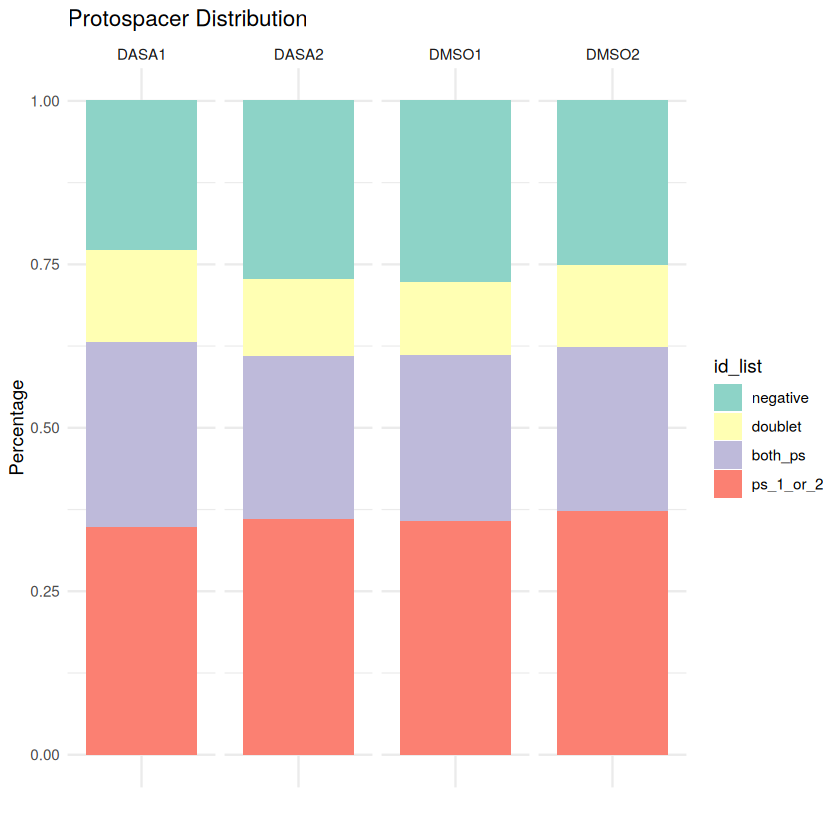

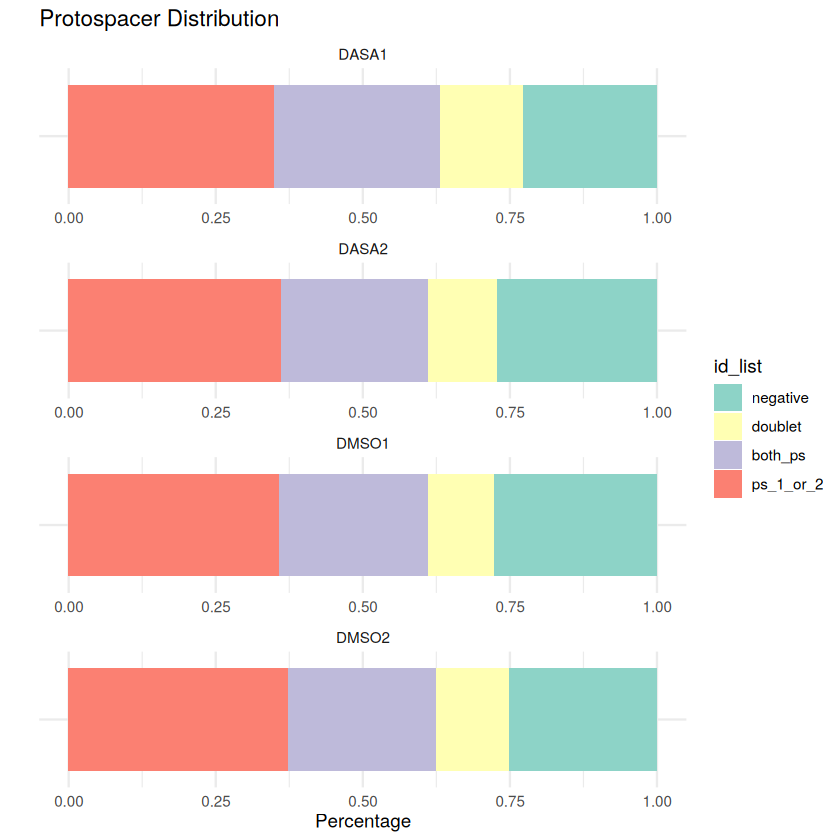

In [11]:
# Combine data frames
# uncomment to include cond9
# combined_df <- bind_rows(cond9_counts, dasa1_counts, dasa2_counts, dmso1_counts, dmso2_counts)
combined_df <- bind_rows(dasa1_counts, dasa2_counts, dmso1_counts, dmso2_counts)

# Calculate total for each dataset
combined_df <- combined_df %>%
  group_by(dataset) %>%
  mutate(total = sum(Freq)) %>%
  ungroup() %>%
  mutate(Percent = Freq / total * 100)

# Set plotting order
combined_df$id_list <- factor(combined_df$id_list, levels = c("negative", "doublet", "both_ps", "ps_1_or_2"))


# Create percent stacked bar plot using facets, vertical
ggplot(combined_df, aes(x = Percent, y = "", fill = id_list)) +
  geom_bar(stat = "identity", position = "fill") +
  labs(title = "Protospacer Distribution", x = "Percentage", y = "") +
  scale_fill_brewer(palette = "Set3") +
  theme_minimal() +
  coord_flip() +
  facet_wrap(~dataset, scales = "free_x", ncol = 5)

# horizontal
ggplot(combined_df, aes(x = Percent, y = "", fill = id_list)) +
  geom_bar(stat = "identity", position = "fill") +
  labs(title = "Protospacer Distribution", x = "Percentage", y = "") +
  scale_fill_brewer(palette = "Set3") +
  theme_minimal() +
  facet_wrap(~dataset, scales = "free_x", ncol = 1)
  

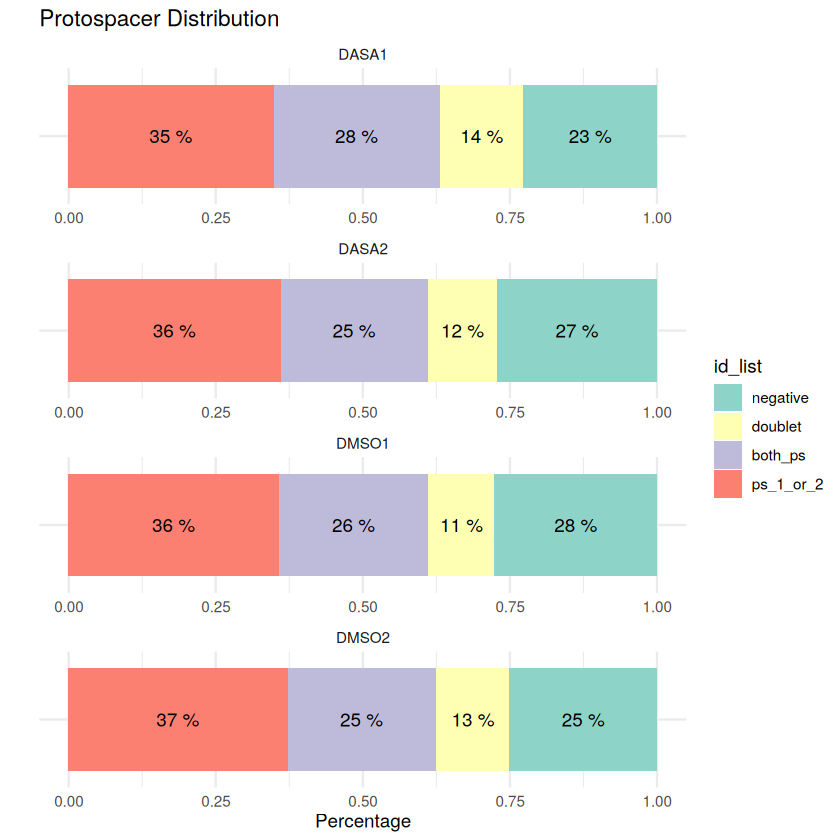

In [10]:
library(ggplot2)
library(dplyr)

# Combine data frames
# combined_df <- bind_rows(cond9_counts, dasa1_counts, dasa2_counts, dmso1_counts, dmso2_counts)
combined_df <- bind_rows(dasa1_counts, dasa2_counts, dmso1_counts, dmso2_counts)
# Calculate total for each dataset and percentages
combined_df <- combined_df %>%
  group_by(dataset) %>%
  mutate(total = sum(Freq),
         Percent = Freq / total * 100) %>%
  ungroup()

# Set plotting order
combined_df$id_list <- factor(combined_df$id_list, levels = c("negative", "doublet", "both_ps", "ps_1_or_2"))

# Create percent stacked bar plot using facets, vertical
ggplot(combined_df, aes(x = "", y = Percent, fill = id_list)) +
  geom_bar(stat = "identity", position = "fill") +
  labs(title = "Protospacer Distribution", y = "Percentage", x = "") +
  scale_fill_brewer(palette = "Set3") +
  theme_minimal() +
  coord_flip() +
  facet_wrap(~dataset, scales = "free_x", ncol = 1) +
  geom_text(aes(label = paste(round(Percent), "%"), y = Percent), position = position_fill(vjust = 0.5))

# # horizontal
# ggplot(combined_df, aes(x = Percent, y = "", fill = id_list)) +
#   geom_bar(stat = "identity", position = "fill") +
#   labs(title = "Protospacer Distribution", x = "Percentage", y = "") +
#   scale_fill_brewer(palette = "Set3") +
#   theme_minimal() +
#   coord_flip() +
#   facet_wrap(~dataset, scales = "free_x", ncol = 5) +
#   geom_text(aes(label = paste(round(Percent), "%"), x = Percent))
